## Recommendation System- Collaborative filtering

### User-based collaborative filtering

#### Import necessary library

In [1]:
import pandas as pd 
import psutil
import dask.dataframe as ddf
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation
import numpy as np
from sklearn.decomposition import TruncatedSVD

In [2]:
memory_position_1 = psutil.virtual_memory()
data = ddf.read_csv('song_data.csv')
memory_position_2 = psutil.virtual_memory()
memory_used_ddf = (memory_position_2[3]-memory_position_1[3])/(1024*1024)
print('memory used by ddf method: %.4f MB'%memory_used_ddf)

memory_position_3 = psutil.virtual_memory()
data = pd.read_csv('song_data.csv')
memory_position_4 = psutil.virtual_memory()
memory_used_pd = (memory_position_4[3]-memory_position_3[3])/(1024*1024)
print('memory used by pandas method: %.4f MB'%memory_used_pd)

memory used by ddf method: 4.7461 MB
memory used by pandas method: 100.7891 MB


In [3]:
data.head()

,user_id,song_id,listen_count,title,artist,song
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Jack Johnson,The Cove - Jack Johnson
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Paco De Lucia,Entre Dos Aguas - Paco De Lucia
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Kanye West,Stronger - Kanye West
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,Jack Johnson,Constellations - Jack Johnson
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,Foo Fighters,Learn To Fly - Foo Fighters


In [4]:
data.shape

(1116609, 6)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1116609 entries, 0 to 1116608
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   user_id       1116609 non-null  object
 1   song_id       1116609 non-null  object
 2   listen_count  1116609 non-null  int64 
 3   title         1116609 non-null  object
 4   artist        1116609 non-null  object
 5   song          1116609 non-null  object
dtypes: int64(1), object(5)
memory usage: 51.1+ MB


In [6]:
data.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
artist          object
song            object
dtype: object

In [7]:
data.isna().sum()

user_id         0
song_id         0
listen_count    0
title           0
artist          0
song            0
dtype: int64

In [8]:
n_counts_userid = len(data['user_id'].unique())
n_counts_songs_id = len(data['song_id'].unique())
n_counts_listencounts = len(data['listen_count'].unique())
n_counts_title = len(data['title'].unique())
n_counts_artist = len(data['artist'].unique())
n_counts_songs = len(data['song'].unique())

In [9]:
print('number of user_id: ',n_counts_userid)
print('number of songs_id: ',n_counts_songs_id)
print('number of listen_counts: ',n_counts_listencounts)
print('number of title: ',n_counts_title)
print('number of artist: ',n_counts_artist)
print('number of songs: ',n_counts_songs)

number of user_id:  66346
number of songs_id:  10000
number of listen_counts:  276
number of title:  9566
number of artist:  3375
number of songs:  9952


In [10]:
label_encoder = LabelEncoder()
data['user_id'] = label_encoder.fit_transform(data['user_id'])
data['song_id'] = label_encoder.fit_transform(data['song_id'])

In [11]:
data.head()

,user_id,song_id,listen_count,title,artist,song
0,47729,153,1,The Cove,Jack Johnson,The Cove - Jack Johnson
1,47729,413,2,Entre Dos Aguas,Paco De Lucia,Entre Dos Aguas - Paco De Lucia
2,47729,736,1,Stronger,Kanye West,Stronger - Kanye West
3,47729,750,1,Constellations,Jack Johnson,Constellations - Jack Johnson
4,47729,1188,1,Learn To Fly,Foo Fighters,Learn To Fly - Foo Fighters


In [12]:
user_frequency = data[['user_id','song_id']].groupby('user_id').count().reset_index()
user_frequency.columns = ['user_id','n_listen_count']
user_frequency.head()

,user_id,n_listen_count
0,0,7
1,1,5
2,2,9
3,3,10
4,4,9


In [13]:
user_frequency.shape

(66346, 2)

In [14]:
mean_listen_count = data.groupby('user_id')[['listen_count']].mean()
mean_listen_count.head()

,listen_count
user_id,
0,2.428571
1,1.200000
2,2.666667
3,3.000000
4,1.111111


In [15]:
lower_mean_listen_count = mean_listen_count['listen_count'].idxmin()
data.loc[data['user_id']==lower_mean_listen_count]

,user_id,song_id,listen_count,title,artist,song
523971,15,1069,1,Give It Up (LP Version),Pepper,Give It Up (LP Version) - Pepper
523972,15,3292,1,Tequila,The Champs,Tequila - The Champs
523973,15,8495,1,The Message,Grandmaster Flash & The Furious Five,The Message - Grandmaster Flash & The Furious ...


In [16]:
highest_mean_listen_count = mean_listen_count['listen_count'].idxmax()
data.loc[data['user_id']==highest_mean_listen_count]

,user_id,song_id,listen_count,title,artist,song
420918,50100,6386,28,He Wasn\'t Man Enough,Toni Braxton,He Wasn\'t Man Enough - Toni Braxton
420919,50100,9814,356,Officially Missing You (Radio Version),Tamia,Officially Missing You (Radio Version) - Tamia


In [17]:
top_20_songs = pd.DataFrame(data.groupby('song')['listen_count'].sum().sort_values(ascending=False).head(20))
top_20_songs.head()

,listen_count
song,
You\'re The One - Dwight Yoakam,40619
Undo - Björk,36059
Revelry - Kings Of Leon,30391
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile) - Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner,21953
Sehr kosmisch - Harmonia,21646


In [18]:
data.groupby('song')['listen_count'].mean().sort_values(ascending=False).head()

song
Crack Under Pressure - Righteous Pigs           22.137255
221 - keller williams                           19.866071
The Quest - HYPOCRISY                           15.380952
Working With Homesick - Homesick James          15.376344
Clara meets Slope - Hard To Say - Clara Hill    15.017699
Name: listen_count, dtype: float64

In [19]:
data.groupby('song')['listen_count'].count().sort_values(ascending=False).head()

song
Sehr kosmisch - Harmonia                                   5970
Undo - Björk                                               5281
You\'re The One - Dwight Yoakam                            4806
Dog Days Are Over (Radio Edit) - Florence + The Machine    4536
Revelry - Kings Of Leon                                    4339
Name: listen_count, dtype: int64

In [20]:
listen_count_mean = pd.DataFrame(data.groupby('song')['listen_count'].mean())
listen_count_mean.head()

,listen_count
song,
#!*@ You Tonight [Featuring R. Kelly] (Explicit Album Version) - The Notorious B.I.G.,2.173913
#40 - DAVE MATTHEWS BAND,5.685864
& Down - Boys Noize,1.934307
(Anaesthesia) Pulling Teath - Metallica,2.527778
(Antichrist Television Blues) - Arcade Fire,1.571429


In [21]:
listen_count_mean['listen_count_avg'] = pd.DataFrame(data.groupby('song')['listen_count'].count())
listen_count_mean.head()

,listen_count,listen_count_avg
song,,
#!*@ You Tonight [Featuring R. Kelly] (Explicit Album Version) - The Notorious B.I.G.,2.173913,46
#40 - DAVE MATTHEWS BAND,5.685864,191
& Down - Boys Noize,1.934307,137
(Anaesthesia) Pulling Teath - Metallica,2.527778,36
(Antichrist Television Blues) - Arcade Fire,1.571429,63


### Visualization 

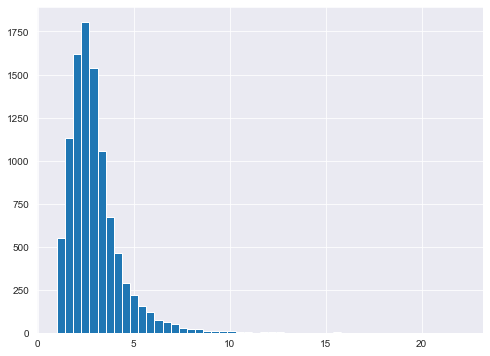

In [22]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,6))
plt.hist(listen_count_mean['listen_count'],bins=50)
plt.show()

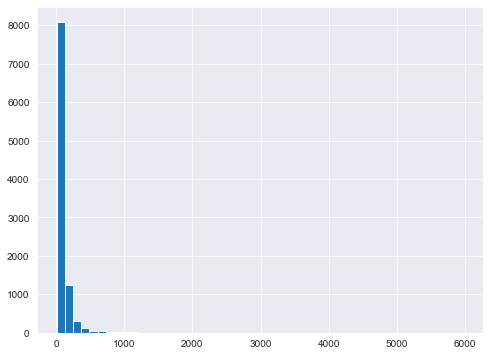

In [23]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,6))
plt.hist(listen_count_mean['listen_count_avg'],bins=50)
plt.show()

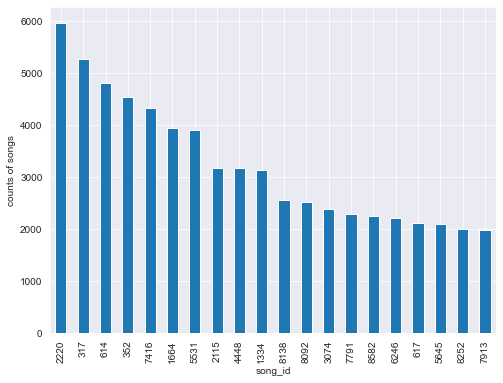

In [24]:
plt.figure(figsize=(8,6))
data['song_id'].value_counts().head(20).plot(kind = 'bar')
plt.xlabel('song_id')
plt.ylabel('counts of songs')
plt.show()

### User Base collaborative filtering

In [25]:
df_10 = data[data['listen_count']>10]
df_10

,user_id,song_id,listen_count,title,artist,song
76,19624,1811,13,Ghosts \'n\' Stuff (Original Instrumental Mix),Deadmau5,Ghosts \'n\' Stuff (Original Instrumental Mix)...
86,19624,8773,18,Push It,Salt-N-Pepa,Push It - Salt-N-Pepa
87,19624,9037,12,Speechless,Lady GaGa,Speechless - Lady GaGa
112,57937,8861,11,Corn Bread,DAVE MATTHEWS BAND,Corn Bread - DAVE MATTHEWS BAND
128,40422,8270,16,Raining Again (Steve Angello\'s Vocal Mix),Moby,Raining Again (Steve Angello\'s Vocal Mix) - Moby
...,...,...,...,...,...,...
1116570,43955,3050,11,Terre Promise,O\'Rosko Raricim,Terre Promise - O\'Rosko Raricim
1116571,43955,3488,31,End Of The Road,Boyz II Men,End Of The Road - Boyz II Men
1116572,43955,3743,19,Suffocate,J. Holiday,Suffocate - J. Holiday
1116573,43955,3894,29,Hypnotized (featuring Akon) (Explicit Album Ve...,Plies featuring Akon,Hypnotized (featuring Akon) (Explicit Album Ve...


In [26]:
data_subset = data[['user_id','song','listen_count']]
data_subset.head()

,user_id,song,listen_count
0,47729,The Cove - Jack Johnson,1
1,47729,Entre Dos Aguas - Paco De Lucia,2
2,47729,Stronger - Kanye West,1
3,47729,Constellations - Jack Johnson,1
4,47729,Learn To Fly - Foo Fighters,1


In [27]:
data_subset.shape

(1116609, 3)

In [28]:
data_subset_10 = data_subset[data_subset['listen_count']>10]
data_subset_10

,user_id,song,listen_count
76,19624,Ghosts \'n\' Stuff (Original Instrumental Mix)...,13
86,19624,Push It - Salt-N-Pepa,18
87,19624,Speechless - Lady GaGa,12
112,57937,Corn Bread - DAVE MATTHEWS BAND,11
128,40422,Raining Again (Steve Angello\'s Vocal Mix) - Moby,16
...,...,...,...
1116570,43955,Terre Promise - O\'Rosko Raricim,11
1116571,43955,End Of The Road - Boyz II Men,31
1116572,43955,Suffocate - J. Holiday,19
1116573,43955,Hypnotized (featuring Akon) (Explicit Album Ve...,29


In [31]:
user_recom_10 = pd.pivot_table(data=data_subset_10,columns='song',index='user_id',values='listen_count')
user_recom_10

song,#!*@ You Tonight [Featuring R. Kelly] (Explicit Album Version) - The Notorious B.I.G.,#40 - DAVE MATTHEWS BAND,& Down - Boys Noize,(Anaesthesia) Pulling Teath - Metallica,(I Cant Get No) Satisfaction - Cat Power,(I Can\'t Get Me No) Satisfaction - Devo,(I Got That) Boom Boom - Britney Spears featuring Ying Yang Twins,(I Just) Died In Your Arms - Cutting Crew,(I\'ve Had) The Time Of My Life - Bill Medley & Jennifer Warnes,(If You\'re Wondering If I Want You To) I Want You To - Weezer,...,aNYway - Armand Van Helden & A-TRAK Present Duck Sauce,in white rooms - Booka Shade,mOBSCENE - Marilyn Manson,paranoid android - Christopher O\'Riley,re:stacks - Bon Iver,sillyworld (Album Version) - Stone Sour,teachme (Album Version) - Musiq Soulchild,the Love Song - K-OS,¡Viva La Gloria! (Album Version) - Green Day,Época - Gotan Project
user_id,,,,,,,,,,,,,,,,,,,,,
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
user_recom_10.index = data_subset_10.user_id.unique()

In [33]:
user_recom_10.fillna(0,inplace=True)

In [34]:
user_recom_10

song,#!*@ You Tonight [Featuring R. Kelly] (Explicit Album Version) - The Notorious B.I.G.,#40 - DAVE MATTHEWS BAND,& Down - Boys Noize,(Anaesthesia) Pulling Teath - Metallica,(I Cant Get No) Satisfaction - Cat Power,(I Can\'t Get Me No) Satisfaction - Devo,(I Got That) Boom Boom - Britney Spears featuring Ying Yang Twins,(I Just) Died In Your Arms - Cutting Crew,(I\'ve Had) The Time Of My Life - Bill Medley & Jennifer Warnes,(If You\'re Wondering If I Want You To) I Want You To - Weezer,...,aNYway - Armand Van Helden & A-TRAK Present Duck Sauce,in white rooms - Booka Shade,mOBSCENE - Marilyn Manson,paranoid android - Christopher O\'Riley,re:stacks - Bon Iver,sillyworld (Album Version) - Stone Sour,teachme (Album Version) - Musiq Soulchild,the Love Song - K-OS,¡Viva La Gloria! (Album Version) - Green Day,Época - Gotan Project
19624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
user_sim =1-pairwise_distances(user_recom_10.values,metric='cosine')
user_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [36]:
df_user_sim = pd.DataFrame(data=user_sim,columns=user_recom_10.index,index=user_recom_10.index)
df_user_sim 

,19624,57937,40422,43683,2789,33516,41891,11198,37571,61610,...,65900,64484,47004,26877,37625,15164,48082,14812,40044,43955
19624,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57937,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40422,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43683,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2789,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
48082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
40044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [37]:
np.fill_diagonal(df_user_sim.to_numpy(),0)
df_user_sim.iloc[0:10,0:10]

,19624,57937,40422,43683,2789,33516,41891,11198,37571,61610
19624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
df_user_sim.idxmax()

19624    58493
57937    58029
40422    44205
43683     1921
2789     24256
         ...  
15164     8090
48082    10871
14812    14515
40044    65939
43955    59470
Length: 21874, dtype: int64

In [39]:
data_subset_10[(data_subset_10['user_id']==43955)|(data_subset_10['user_id']==59470)]

,user_id,song,listen_count
808524,59470,Undo - Björk,30
808532,59470,Revelry - Kings Of Leon,155
808534,59470,Hasta La Vista - Jordan Francis/Roshon Bernard...,40
808536,59470,Itchy Feet - Leggo Beast,12
1116570,43955,Terre Promise - O\'Rosko Raricim,11
1116571,43955,End Of The Road - Boyz II Men,31
1116572,43955,Suffocate - J. Holiday,19
1116573,43955,Hypnotized (featuring Akon) (Explicit Album Ve...,29
1116575,43955,Bed - J. Holiday,26


In [40]:
data_subset_10[(data_subset_10['user_id']==19624)|(data_subset_10['user_id']==58493)]

,user_id,song,listen_count
76,19624,Ghosts \'n\' Stuff (Original Instrumental Mix)...,13
86,19624,Push It - Salt-N-Pepa,18
87,19624,Speechless - Lady GaGa,12
135077,58493,Australia (Album) - The Shins,11
135079,58493,Salgo Pa\' La Calle - Daddy Yankee / Randy,13


#### Item-base collaborative filtering 

In [41]:
data_subset.head()

,user_id,song,listen_count
0,47729,The Cove - Jack Johnson,1
1,47729,Entre Dos Aguas - Paco De Lucia,2
2,47729,Stronger - Kanye West,1
3,47729,Constellations - Jack Johnson,1
4,47729,Learn To Fly - Foo Fighters,1


In [42]:
df = data_subset[data_subset['listen_count']>10]
df 

,user_id,song,listen_count
76,19624,Ghosts \'n\' Stuff (Original Instrumental Mix)...,13
86,19624,Push It - Salt-N-Pepa,18
87,19624,Speechless - Lady GaGa,12
112,57937,Corn Bread - DAVE MATTHEWS BAND,11
128,40422,Raining Again (Steve Angello\'s Vocal Mix) - Moby,16
...,...,...,...
1116570,43955,Terre Promise - O\'Rosko Raricim,11
1116571,43955,End Of The Road - Boyz II Men,31
1116572,43955,Suffocate - J. Holiday,19
1116573,43955,Hypnotized (featuring Akon) (Explicit Album Ve...,29


In [43]:
crosstab_data = pd.pivot_table(data=df,columns='song',index='user_id',values='listen_count').fillna(0)
crosstab_data

song,#!*@ You Tonight [Featuring R. Kelly] (Explicit Album Version) - The Notorious B.I.G.,#40 - DAVE MATTHEWS BAND,& Down - Boys Noize,(Anaesthesia) Pulling Teath - Metallica,(I Cant Get No) Satisfaction - Cat Power,(I Can\'t Get Me No) Satisfaction - Devo,(I Got That) Boom Boom - Britney Spears featuring Ying Yang Twins,(I Just) Died In Your Arms - Cutting Crew,(I\'ve Had) The Time Of My Life - Bill Medley & Jennifer Warnes,(If You\'re Wondering If I Want You To) I Want You To - Weezer,...,aNYway - Armand Van Helden & A-TRAK Present Duck Sauce,in white rooms - Booka Shade,mOBSCENE - Marilyn Manson,paranoid android - Christopher O\'Riley,re:stacks - Bon Iver,sillyworld (Album Version) - Stone Sour,teachme (Album Version) - Musiq Soulchild,the Love Song - K-OS,¡Viva La Gloria! (Album Version) - Green Day,Época - Gotan Project
user_id,,,,,,,,,,,,,,,,,,,,,
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
x = crosstab_data.T
x

user_id,7,11,14,16,17,21,23,24,33,35,...,66307,66308,66310,66314,66315,66316,66317,66325,66333,66336
song,,,,,,,,,,,,,,,,,,,,,
#!*@ You Tonight [Featuring R. Kelly] (Explicit Album Version) - The Notorious B.I.G.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#40 - DAVE MATTHEWS BAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
& Down - Boys Noize,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(Anaesthesia) Pulling Teath - Metallica,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(I Cant Get No) Satisfaction - Cat Power,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sillyworld (Album Version) - Stone Sour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
teachme (Album Version) - Musiq Soulchild,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the Love Song - K-OS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
SVD = TruncatedSVD(n_components=3, random_state=5)
resultant_matrix = SVD.fit_transform(x)
resultant_matrix 

array([[ 8.08529629e-03,  1.64510601e-02,  2.53996875e-04],
       [ 8.10586169e-02,  1.10237739e-01,  3.15664737e-01],
       [ 6.84953944e-06,  2.03644372e-05, -9.61257466e-06],
       ...,
       [ 4.21263734e-02,  1.20559431e-01,  1.29619892e-02],
       [ 7.06109328e-04,  1.53049978e-03,  8.92895819e-04],
       [ 2.41169947e-03,  3.06192800e-04,  1.53083025e-03]])

In [46]:
resultant_matrix.shape

(8237, 3)

In [47]:
corr_matrix = np.corrcoef(resultant_matrix)
corr_matrix

array([[ 1.        , -0.79182745,  0.99713229, ...,  0.97147902,
         0.75026757, -0.59449261],
       [-0.79182745,  1.        , -0.83577685, ..., -0.62442057,
        -0.19029807, -0.02036503],
       [ 0.99713229, -0.83577685,  1.        , ...,  0.95074784,
         0.69808249, -0.53193476],
       ...,
       [ 0.97147902, -0.62442057,  0.95074784, ...,  1.        ,
         0.88564101, -0.76820997],
       [ 0.75026757, -0.19029807,  0.69808249, ...,  0.88564101,
         1.        , -0.97764733],
       [-0.59449261, -0.02036503, -0.53193476, ..., -0.76820997,
        -0.97764733,  1.        ]])

In [48]:
corr_matrix.shape

(8237, 8237)

### Find similar songs 

In [51]:
col_inx = crosstab_data.columns.get_loc('the Love Song - K-OS')
corr_specific = corr_matrix[col_inx]
pd.DataFrame({'corr specific': corr_specific,'songs':crosstab_data.columns}).sort_values('corr specific',ascending=False)\
.head(10)

,corr specific,songs
8234,1.000000,the Love Song - K-OS
2913,1.000000,Hold You - Gyptian
7357,0.999999,Total Eclipse (1998 Digital Remaster) - Iron M...
5628,0.999996,Rhinestone Eyes - Gorillaz
4827,0.999994,No Puedo Evitar (Pensar En Ti) - Duncan Dhu
7595,0.999994,Voices (Album Fade) - Saosin
6893,0.999991,The Girl From Ipanema - Astrud Gilberto
1638,0.999991,Dirty Road - Days Of The New
4278,0.999988,Mama Said - Metallica
5066,0.999985,Only - Nine Inch Nails


In [52]:
col_inx = crosstab_data.columns.get_loc('teachme (Album Version) - Musiq Soulchild')
corr_specific = corr_matrix[col_inx]
pd.DataFrame({'corr specific': corr_specific,'songs':crosstab_data.columns}).sort_values('corr specific',ascending=False)\
.head(10)

,corr specific,songs
8233,1.000000,teachme (Album Version) - Musiq Soulchild
6824,1.000000,The Cigar Song - Brad Paisley
5553,1.000000,Rebels of the Sacred Heart - Flogging Molly
5053,0.999999,One Summer Night - The Danleers
5189,0.999999,Parachute - Cheryl Cole
2179,0.999999,Feel (Album Version) - matchbox twenty
263,0.999997,All Is Love - Karen O And The Kids
1256,0.999997,Close My Eyes Forever - Lita Ford & Ozzy Osborne
1253,0.999992,Clocks - Coldplay
755,0.999992,Bird Song Intro - Florence + The Machine
